In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
#plt.style.reload_library()
#plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 829.19it/s]


In [9]:
# get test data set
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 847.98it/s]


In [10]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [12]:
x.shape

torch.Size([32, 5])

In [13]:
c.shape

torch.Size([32, 40])

In [14]:
w.shape

torch.Size([32, 40])

In [15]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [18]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [19]:
# training
twostage_model.fit(sp_dataset_train.feats, sp_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.feats)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.costs[i]
    z_true_i = sp_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(sp_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(sp_dataset_test.objs.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.53it/s]


Normalized Regret: 1.61%
Normalized Unambiguous Regret: 1.61%


In [22]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: " + ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.28, 0.16, 0.55, -0.67, 0.99, -0.21, -0.41, 0.30, -0.19, 0.41, -0.21, 0.04, -0.57, 0.30, -0.33, 0.30, -0.84, 0.20, 0.05, -0.21, 0.04, 0.20, 0.57, -0.09, 0.79, -0.41, -0.33, -0.33, 0.46, 0.55, 0.33, -0.57, 0.33, 0.16, 0.55, 0.55, -0.41, 0.55, -0.05, 0.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10

## Linear Regression from PyTorch

In [23]:
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [27]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [28]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:   0.4476, Regret:  1.9581%, Unambiguous Regret:  1.9581%
Epoch   5, Loss:   0.2181, Regret:  0.5344%, Unambiguous Regret:  0.5344%
Epoch  10, Loss:   0.0804, Regret:  0.4958%, Unambiguous Regret:  0.4958%
Epoch  15, Loss:   0.3556, Regret:  0.5125%, Unambiguous Regret:  0.5125%
Epoch  20, Loss:   0.0000, Regret:  0.5177%, Unambiguous Regret:  0.5177%
Epoch  25, Loss:   0.5209, Regret:  0.4222%, Unambiguous Regret:  0.4222%
Epoch  30, Loss:   0.0937, Regret:  0.5114%, Unambiguous Regret:  0.5114%
Epoch  35, Loss:   0.1766, Regret:  0.4536%, Unambiguous Regret:  0.4536%
Epoch  40, Loss:   0.5476, Regret:  0.5581%, Unambiguous Regret:  0.5581%
Epoch  45, Loss:   0.0601, Regret:  0.4854%, Unambiguous Regret:  0.4854%
Epoch  50, Loss:   0.0254, Regret:  0.4886%, Unambiguous Regret:  0.4886%
Epoch  55, Loss:   0.0193, Regret:  0.4634%, Unambiguous Regret:  0.4634%
Epoch  60, Loss:   0.1280, Regret:  0.4516%, Unambiguous Regret:  0.4516%
Epoch  65, Loss:   0.1132, Regret:  0.

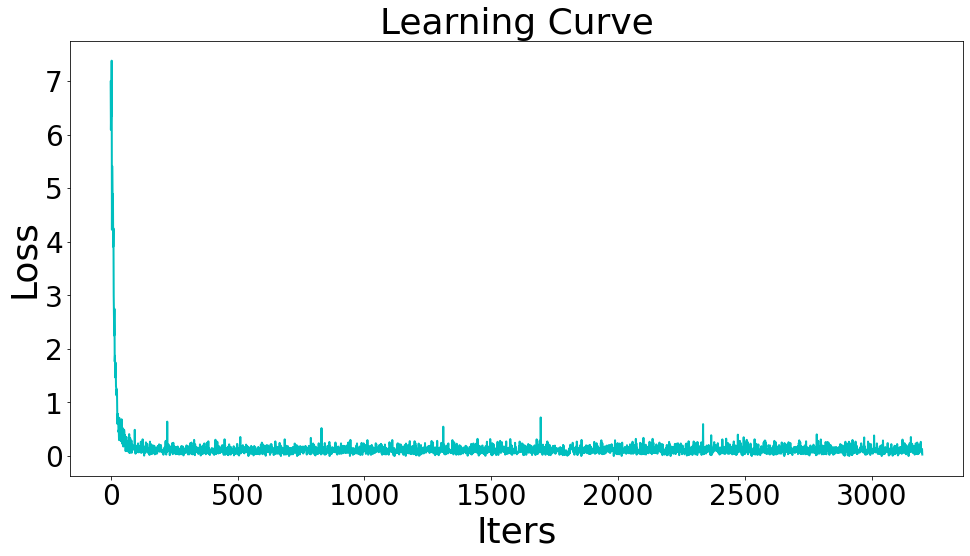

In [29]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

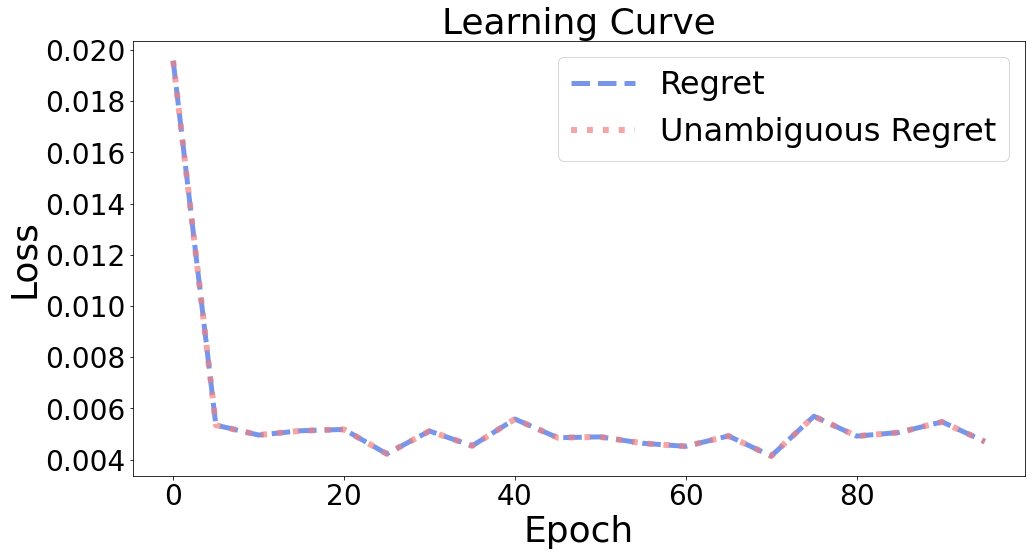

In [30]:
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/regret_curve01.pdf", dpi=300)

In [31]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.46%
Normalized Unambiguous Regret: 0.46%


In [32]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -1.31, 0.12, 0.71, 0.69, 1.35, -0.21, 0.17, -0.14, -0.19, 1.52, -0.88, -0.79, -0.20, 0.85, -0.28, 1.61, -1.41, -0.93, 0.72, -0.50, -0.81, -0.62, -0.10, -0.03, -0.10, -0.62, 0.01, 0.51, -0.38, 2.20, 0.16, -0.86, -0.33, -0.85, 0.32, -0.30, 0.05, -0.34, 0.69, -0.72
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.

##  SPO+ with Regularization

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [35]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [36]:
# train model
num_epochs = 100
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).mean(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:   0.4405, Regret:  2.4470%, Unambiguous Regret:  2.4470%
Epoch   5, Loss:   0.1958, Regret:  0.4668%, Unambiguous Regret:  0.4669%
Epoch  10, Loss:   0.0487, Regret:  0.5013%, Unambiguous Regret:  0.5013%
Epoch  15, Loss:   0.0009, Regret:  0.5376%, Unambiguous Regret:  0.5376%
Epoch  20, Loss:   0.0072, Regret:  0.4576%, Unambiguous Regret:  0.4576%
Epoch  25, Loss:   0.1497, Regret:  0.4990%, Unambiguous Regret:  0.4990%
Epoch  30, Loss:   0.1025, Regret:  0.4485%, Unambiguous Regret:  0.4485%
Epoch  35, Loss:   0.0113, Regret:  0.5455%, Unambiguous Regret:  0.5455%
Epoch  40, Loss:   0.4178, Regret:  0.4760%, Unambiguous Regret:  0.4760%
Epoch  45, Loss:   0.2578, Regret:  0.4781%, Unambiguous Regret:  0.4781%
Epoch  50, Loss:   0.3149, Regret:  0.4295%, Unambiguous Regret:  0.4295%
Epoch  55, Loss:   0.0055, Regret:  0.5091%, Unambiguous Regret:  0.5091%
Epoch  60, Loss:   0.0118, Regret:  0.4236%, Unambiguous Regret:  0.4236%
Epoch  65, Loss:   0.0445, Regret:  0.

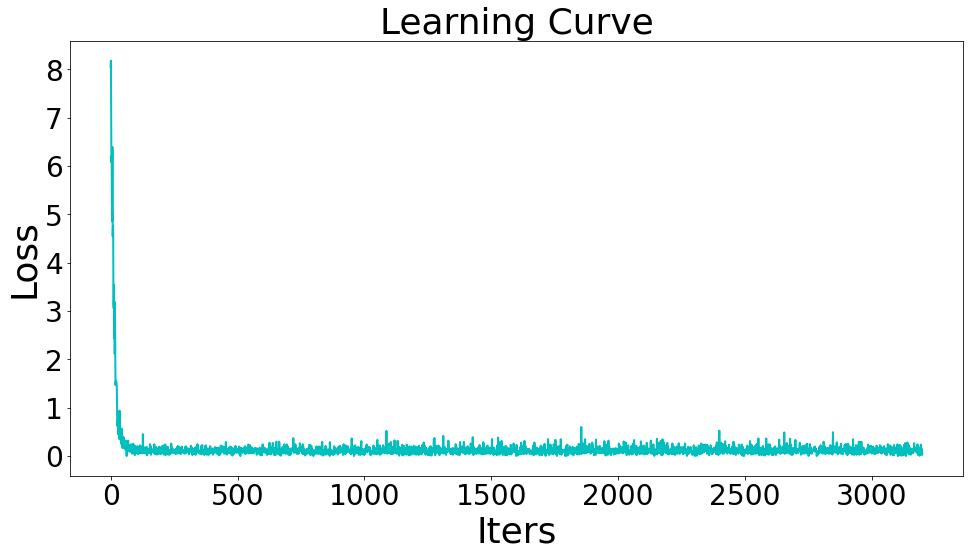

In [37]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

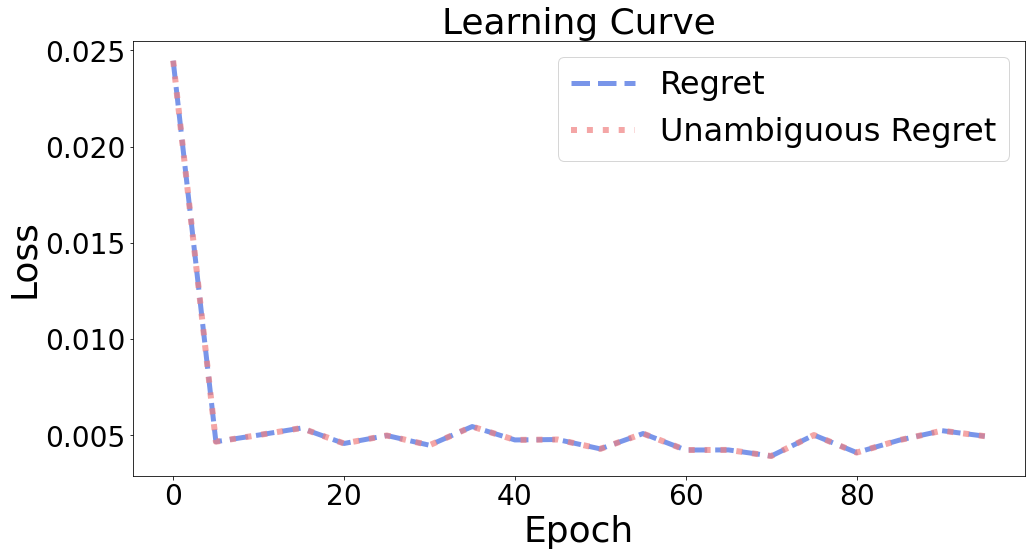

In [38]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [39]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.59%
Normalized Unambiguous Regret: 0.59%


In [40]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -1.33, 0.11, -0.18, -0.65, 1.42, -1.42, -0.95, -0.18, 0.99, 0.26, -0.31, -0.88, -0.38, -0.37, -0.13, 1.60, -0.86, -0.04, 0.74, -0.00, -0.38, -0.78, 0.68, 0.55, 1.21, -1.06, -0.55, 0.11, 0.72, 0.84, -0.05, 0.55, 0.92, -0.72, 0.49, 0.20, -0.54, -0.40, -0.72, -0.13
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.34

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.

## Black-Box

In [41]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [42]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [43]:
# set loss
criterion = nn.L1Loss()
dbb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)

Num of cores: 4


In [44]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:   0.6998, Regret: 16.7381%, Unambiguous Regret: 16.7381%
Epoch   5, Loss:   0.2449, Regret:  7.6790%, Unambiguous Regret:  7.6791%
Epoch  10, Loss:   0.1162, Regret:  6.5457%, Unambiguous Regret:  6.5458%
Epoch  15, Loss:   1.4729, Regret:  4.5743%, Unambiguous Regret:  4.5743%
Epoch  20, Loss:   0.6670, Regret:  7.6048%, Unambiguous Regret:  7.6049%
Epoch  25, Loss:   0.1518, Regret:  7.5927%, Unambiguous Regret:  7.5929%
Epoch  30, Loss:   0.7386, Regret: 12.5749%, Unambiguous Regret: 12.5751%
Epoch  35, Loss:   0.1090, Regret:  6.4036%, Unambiguous Regret:  6.4037%
Epoch  40, Loss:   0.1754, Regret: 12.7094%, Unambiguous Regret: 12.7095%
Epoch  45, Loss:   0.2971, Regret:  5.2121%, Unambiguous Regret:  5.2121%
Epoch  50, Loss:   0.3373, Regret:  9.8508%, Unambiguous Regret:  9.8508%
Epoch  55, Loss:   0.1507, Regret:  7.8483%, Unambiguous Regret:  7.8484%
Epoch  60, Loss:   0.1804, Regret: 10.5236%, Unambiguous Regret: 10.5238%
Epoch  65, Loss:   1.2336, Regret:  8.

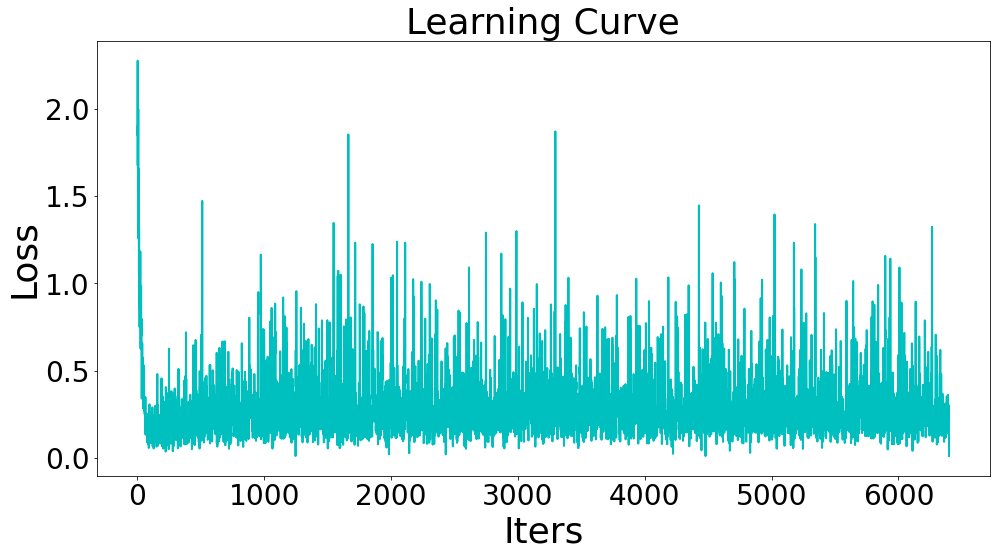

In [45]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

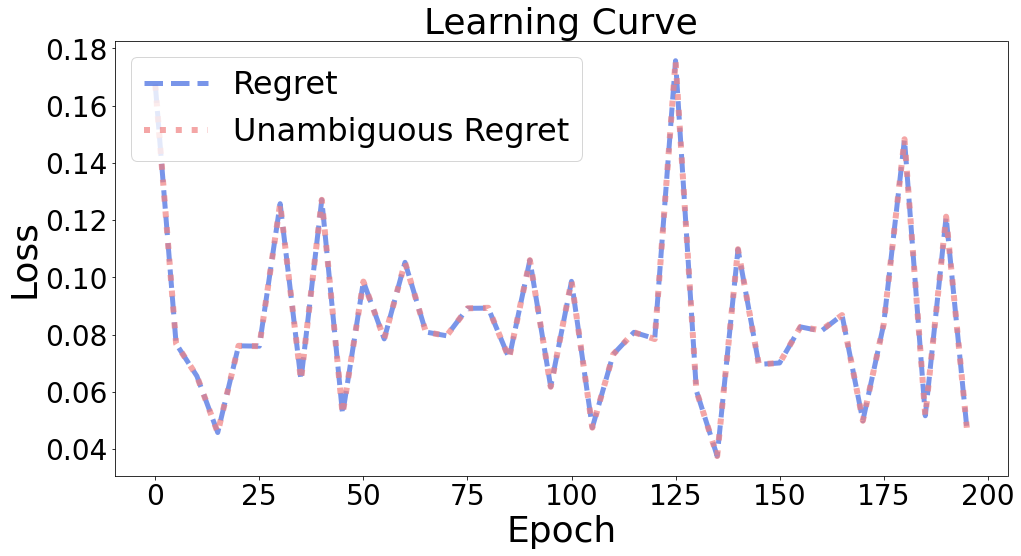

In [46]:
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/regret_curve02.pdf", dpi=300)

In [47]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 15.66%
Normalized Unambiguous Regret: 15.66%


In [48]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.80, 0.83, -0.14, -0.03, -0.61, -0.21, -0.98, -0.33, -1.11, 1.29, 0.04, -0.39, 0.51, 0.14, -0.95, -0.55, 0.50, -0.54, 0.15, 0.45, 0.76, 0.10, 1.49, 0.57, -0.03, -0.51, 0.19, 0.77, -0.14, 0.32, -0.29, -0.07, 0.93, 1.07, 0.82, -0.21, 0.34, 1.92, -0.04, -1.26
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.38

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0

## Black-Box with Regularization

In [49]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [50]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [51]:
# set loss
dbb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [52]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-5
        l1_reg = torch.abs(cp - c).mean(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous regret
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), trueloss*100, unambloss*100))

Epoch   0, Loss:   0.2625, Regret:  9.7209%, Unambiguous Regret:  9.7209%
Epoch   5, Loss:   0.0515, Regret:  2.6875%, Unambiguous Regret:  2.6875%
Epoch  10, Loss:   0.4549, Regret:  6.2967%, Unambiguous Regret:  6.2967%
Epoch  15, Loss:   0.0314, Regret:  9.4995%, Unambiguous Regret:  9.4996%
Epoch  20, Loss:   0.5996, Regret: 11.8291%, Unambiguous Regret: 11.8291%
Epoch  25, Loss:   0.0746, Regret:  6.1381%, Unambiguous Regret:  6.1382%
Epoch  30, Loss:   0.2883, Regret:  8.5983%, Unambiguous Regret:  8.5984%
Epoch  35, Loss:   0.1419, Regret:  6.8622%, Unambiguous Regret:  6.8623%
Epoch  40, Loss:   0.0450, Regret:  4.7832%, Unambiguous Regret:  4.7833%
Epoch  45, Loss:   0.1094, Regret:  5.8630%, Unambiguous Regret:  5.8631%
Epoch  50, Loss:   1.1029, Regret: 15.9705%, Unambiguous Regret: 15.9711%
Epoch  55, Loss:   0.1522, Regret: 10.0156%, Unambiguous Regret: 10.0157%
Epoch  60, Loss:   0.1569, Regret:  4.6385%, Unambiguous Regret:  4.6387%
Epoch  65, Loss:   0.4576, Regret:  8.

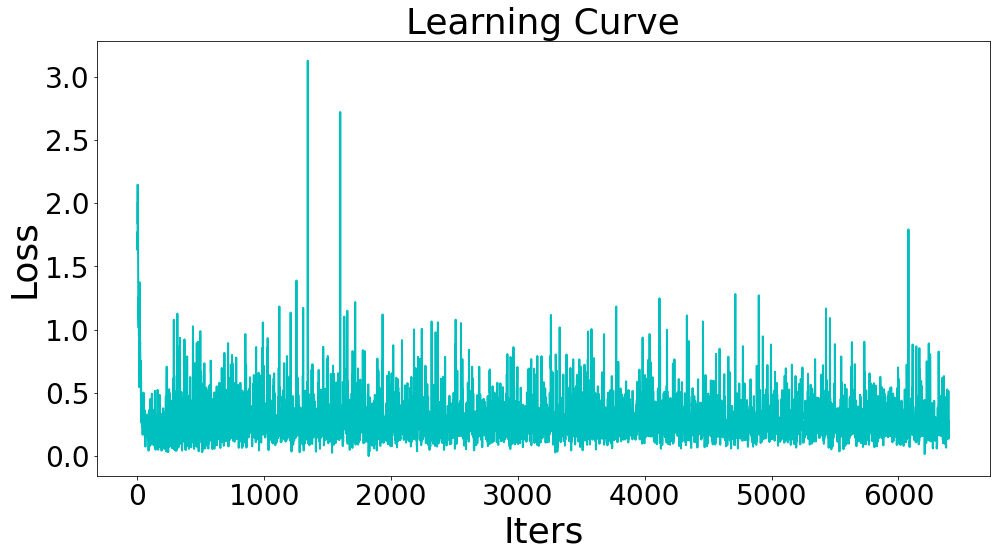

In [53]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

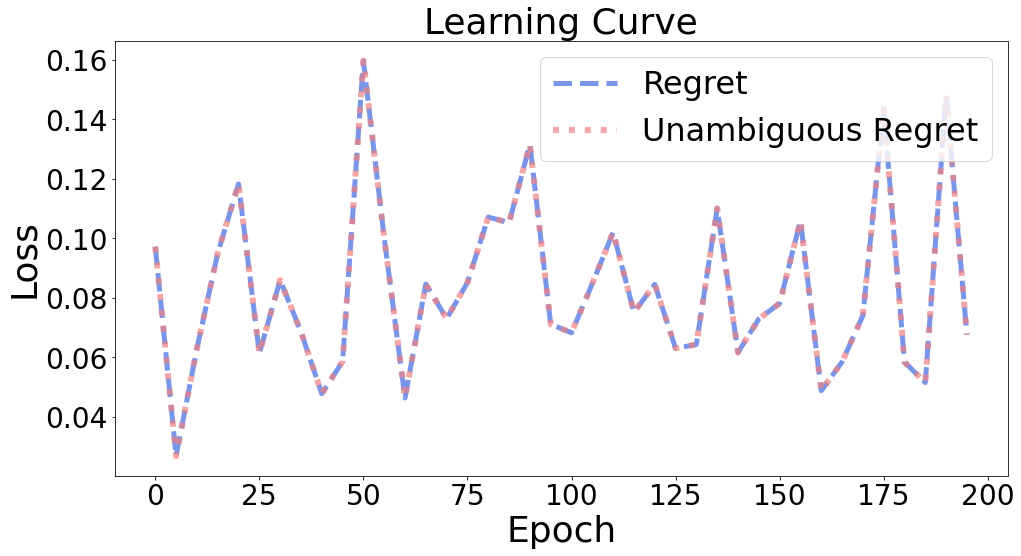

In [54]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [55]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 9.68%
Normalized Unambiguous Regret: 9.68%


In [56]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.31, -0.24, 0.73, -0.58, 0.13, -0.48, -0.55, 0.29, 0.01, -0.19, -0.31, 0.60, 0.90, 0.36, 0.19, 0.29, 0.53, 0.37, -0.49, -0.33, 0.99, 0.52, -0.15, 0.27, -0.19, -0.83, -0.25, 0.50, -0.81, 0.57, 0.54, 1.02, 0.28, 0.51, 0.25, -0.77, 1.10, 1.97, 0.25, -0.41
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.82

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10,